In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!unzip /content/hw5_data.zip

In [ ]:
!ls

---
## <b><font color="blue">Легкая часть</font></b>
### Задача 1

#### *Профиль биология*

Мы будем исследовать датасет по экспрессиям различных генов (RNA-seq), используемых для предсказания возраста пациентов.

In [ ]:
df = pd.read_csv("/content/hw5_data/Rnaseq_age_reg.csv")
df.head()

Разбейте датасет на признаки и таргет, где в качестве таргета будет использоваться столбец `Age`, а признаки - все остальные. В том числе разбейте на подвыборки для обучения и теста.

In [ ]:
X = df.drop('Age', axis = 1)
y = df['Age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

**Переходите к общей части.**

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучите модель линейной регрессии и посмотрите на значения метрик на тесте. Что вы можете сказать про результат обучения?

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
y_linreg_pred = linreg_model.predict(X_test)

linreg = {}
linreg['MSE'] = mean_squared_error(y_test, y_linreg_pred)
linreg['MAE'] = mean_absolute_error(y_test, y_linreg_pred)
linreg['MAPE'] = mean_absolute_percentage_error(y_test, y_linreg_pred)
linreg['R^2'] = r2_score(y_test, y_linreg_pred)

for key,value in linreg.items():
  print(key, ':', value)

**Вывод:**

Наиболее показательной метрикой в контексте данной задачи является $R^2$, так как она принимает отрицательное занчение, что свидетельствует о том, что модель предсказывает хуже, чем простое среднее.


Обучите линейные модели с регуляризациями, которые мы проходили ранее. Для каждой из моделей постройте графики зависимости метрик r2 и MAPE от коэфициента регуляризации. Можно пользоваться кодом из домашнего задания по регуляризации. Сильно ли улучшился результат?

In [ ]:
def draw_errors(error, error_name, alphas):

    """
    Функция строит график зависимости величины ошибки от параметра alpha для разных моделей

    :param error: функция, вычисляющая ошибку
    :param error_name: имя функции, вычисляющей ошибку (одно из 'R^2', 'MAPE')
    :param alphas: массив величин alpha
    """
    arr = [] # массив ошибок
    for a in alphas:
        tmp = [] # массив ошибок
        models = [
            Ridge(alpha = a),
            Lasso(alpha = a),
            ElasticNet(alpha = a, l1_ratio = 0.5),
            linreg_model
        ]
        for model in models:

            # обучение модели и предсказание
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            tmp.append(error(y_test, y_pred))
        arr.append(tmp)

    arr = np.array(arr)
    plt.figure(figsize=(10, 6), dpi=100)

    names = ['Ridge (l1_ratio = 1)', 'Lasso', 'ElasticNet (l1_ratio = 0.5)', 'No regularization']
    for i in range(3):
        plt.plot(alphas, arr[:, i], label=names[i]) # рисуем ошибки в зависимости от alpha

    # прерывистой линией рисуем ошибки логрега без регуляризации
    plt.hlines(linreg[error_name], alphas[0], alphas[-1], color='black', label = 'No regularization', linestyles='dashed')
    plt.xlabel('Параметр регуляризации')
    plt.ylabel(error_name)
    plt.xscale('log')
    plt.legend()

In [ ]:
alphas = np.logspace(-2, 8, 20)

In [ ]:
draw_errors(mean_absolute_percentage_error, 'MAPE', alphas)
draw_errors(r2_score, 'R^2', alphas)

Выберите оптимальный, на вашь взгляд, параметр для L1-регуляризации, обучите модель Lasso-регрессии, выведите ещё раз метрики r2 и MAPE и проведите отбор признаков: уберите из датасета все те, для которых коэффициент регуляризации оказался нулевым.

Оптимальный параметр выберем исходя из максимума на графике $R^2$ и минимума $MAPE$.

In [ ]:
opt_alpha_lasso = 0.1

In [ ]:
lasso_opt_model = Lasso(alpha = opt_alpha_lasso)
lasso_opt_model.fit(X_train, y_train)
y_lasso_opt_pred = lasso_opt_model.predict(X_test)

In [ ]:
linreg_opt = {}
linreg_opt['MAPE'] = mean_absolute_percentage_error(y_test, y_lasso_opt_pred)
linreg_opt['R^2'] = r2_score(y_test, y_lasso_opt_pred)

for key,value in linreg_opt.items():
  print(key, ':', value)

In [ ]:
selected_features = X.columns[lasso_opt_model.coef_ != 0]
X_selected = X[selected_features]
X_selected.head()

Теперь обучите простейшую нейронную сеть на уменьшенном датасете, сравните результат с результатами обучения других моделей.

In [ ]:
X_tensor = torch.FloatTensor(X_selected.values)
y_tensor = torch.FloatTensor(y).reshape(-1, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
model = nn.Sequential(
    nn.Linear(in_features = X_train.shape[1], out_features = 1)
)

In [ ]:
optim_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
epochs = 1000

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = optim_func(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
with torch.no_grad():
    y_pred = model(X_test)

print(f'R2: {round(r2_score(y_test, y_pred), 2)} \nMAPE: {round(mean_absolute_percentage_error(y_test, y_pred), 2)}')

**Вопрос:** объясните полученный результат.

 Нейронная сеть с одним линейным слоем, не содержащим функции активации, может обучиться приближать нелинейные зависимости, аналогичные линейным моделям. Как следствие этого, мы видим, что сеть достигла сопоставимых результатов с Lasso-регрессией.

Сравните все модели, поясняя полученные результаты и значения метрик.

**Вывод:**

I. Метрики Линейной регрессии:
* MAPE: 2.03%
* R^2: -0.22

II. Метрики Линейной регрессии:
* MAPE: 0.69%
* R^2: 0.65

III. Метрики простейшей нейронной сети:
* MAPE: 0.56%
* R^2: 0.72

1. Модель линейной регрессии без регуляризации показала недостаточную способность объяснения дисперсии в данных. Об этом свидетельствует отрицательное значение $R^2$. MAPE в 2.03% - неплохой результат, но все-таки следует учитывать низое значение $R^2$.

2. Использование Lasso с оптимальным параметром позволило улучшить MAPE и $R^2$ по сравнению с обычной линейной регрессией.

3. Простейшая нейронная сеть с одним линейным слоем смогла достичь результатов, сопоставимых с Lasso-регрессией.

**Итог:**

* Модели с регуляризацией (Lasso и простейшая нейронная сеть) продемонстрировали лучшие результаты по метрикам MAPE и $R^2$ по сравнению с обычной линейной регрессией.
* Отбор признаков важен для улучшения показаний моделей в задачах регрессии с большим количеством признаков.
* Простейшая нейронная сеть смогла успешно аппроксимировать нелинейные зависимости, что сделало ее сопоставимой с Lasso-регрессией.

---
### Задача 2





### Профиль биология

Скачайте [датасет](https://miptstats.github.io/courses/ad_mipt.html), описывающий влияние курения и алкоголя на человека. Создайте и обучите нейросеть, разделяющую эти два класса.

[Описание датасета](https://www.kaggle.com/datasets/sooyoungher/smoking-drinking-dataset)

In [ ]:
!unzip /content/archive_smoking_drinking.zip

In [ ]:
!ls

In [ ]:
df = pd.read_csv("smoking_driking_dataset_Ver01.csv")

In [ ]:
df.describe()

In [ ]:
df.columns, df.shape

In [ ]:
column_names = df.columns[1:-2]# нам не нужны гендер и таргеты сейчас

In [ ]:
column_names

Попробуем классифицировать людей с плохими привычками и без них, чтобы облегчить нам задачу. Для этого создадим дополнительный столбец в таблице, который будет содержать информацию о том, имеет ли человек вредные привычки или нет.

In [ ]:
def smoking_preprocessing(x):
  if x == 3 or x == 2:
    return 1
  else:
    return 0

def drinking_preprocessing(x):
  if x == 'Y':
    return 1
  else:
    return 0

In [ ]:
df['SMK_stat_type_cd'] = df['SMK_stat_type_cd'].apply(func = smoking_preprocessing)
df['DRK_YN'] = df['DRK_YN'].apply(func = drinking_preprocessing)

In [ ]:
df['bad_habits'] = df['DRK_YN']+df['SMK_stat_type_cd']-df['DRK_YN']*df['SMK_stat_type_cd']

Теперь смотрим на разделение по привычкам

In [ ]:
graph = sns.PairGrid(df.iloc[:1000], hue='bad_habits', vars = column_names[:7])
graph.map_upper(sns.scatterplot)
graph.map_lower(sns.kdeplot)
graph.map_diag(sns.kdeplot)
graph.add_legend()

In [ ]:
graph = sns.PairGrid(df.iloc[:1000], hue='bad_habits', vars = column_names[7:15])
graph.map_upper(sns.scatterplot)
graph.map_lower(sns.kdeplot)
graph.map_diag(sns.kdeplot)
graph.add_legend()

In [ ]:
graph = sns.PairGrid(df.iloc[:1000], hue='bad_habits', vars = column_names[15:])
graph.map_upper(sns.scatterplot)
graph.map_lower(sns.kdeplot)
graph.map_diag(sns.kdeplot)
graph.add_legend()

In [ ]:
target_1 = df.pop('SMK_stat_type_cd')
target_2 = df.pop('DRK_YN')
target_3 = df.pop('bad_habits')

Какие признаки вы бы использовали для разделения людей по классам? Выберите эти столбцы и создайте наборы train и test с помощью функции train_test_split, а также выделите набор данных для валидации при обучении.

In [ ]:
# Для проверки наших рассуждений отберем фичи с помощью Random Forest
from sklearn.ensemble import RandomForestClassifier

features = df[['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right',
               'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole',
               'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein',
               'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']]

target = target_3

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_classifier.fit(X_train, y_train)

feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': rf_classifier.feature_importances_})
feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False)

print(feature_importances)

In [ ]:
# исходя из графиков, отберём признаки для обучения (нас интересуют вредные привычки)
# возьмем первые 5 для дальнейшего обучения
selected_features = ['height', 'hemoglobin', 'gamma_GTP', 'weight', 'triglyceride']
X = df[selected_features]

In [ ]:
# данных очень много, поэтому для экономии времени автор ноутбука отводит на обучение всего треть датасета
X_train, X_test, y_train, y_test = train_test_split(X, target_3, train_size=0.3)
X_val, X_test, y_val, y_test  = train_test_split(X_test, y_test, train_size=0.3)

## Общая часть

Как вы помните, в задаче классификации предсказывается вероятность. На основании этой вероятности можно делать вывод о принадлежности объекта к тому или иному классу. Причём не всегда используется порог $P=0.5$. Например, если классы несбалансированы, это значение можно варьировать на интервале (0, 1). Предоставляем вам возможность самим выбрать этот порог и поэкспериментировать.

In [ ]:
class_lim_proba = 0.6 # критерий принадлежности к тому или иному классу

Стандартизируйте данные

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.transform(X_val)

Напишем функцию для отрисовки кривых обучения. На одном графике расположим значение функции потерь на трейне и валидации, а на другом &mdash; значение метрики качества на ваш выбор, также для трейна и валидации.

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для отображения лосса и метрики во время обучения.
    '''
    clear_output(wait=True)

    fig = plt.figure(figsize=(20, 7))
    fontsize = 15   # размер шрифта

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=fontsize)
    plt.plot(history['loss_train'], label='train')
    plt.plot(history['loss_val'],   label='val')
    plt.ylabel('лосс',  fontsize=fontsize)
    plt.xlabel('эпоха', fontsize=fontsize)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Метрика', fontsize=fontsize)
    plt.plot(history['metric_train'], label='train')
    plt.plot(history['metric_val'],   label='val')
    plt.ylabel('Значение метрики', fontsize=fontsize)
    plt.xlabel('эпоха', fontsize=fontsize)
    plt.legend()
    plt.show()

Напишите функцию метрики, которую вы будете использовать, например accuracy.

In [ ]:
def metric(y_true, y_pred):
  return accuracy_score(y_true, y_pred)

#### Создание модели.
В семинаре вы у промежуточных слоёв задавали `in_features = out_features = 1`, а в данном случае вам надо будет создать нейросеть из нескольких слоёв, поставив только у последнего из них `out_features = 1`.

Какой должна быть размерность входа первого слоя?

In [ ]:
model = nn.Sequential(
    nn.Linear(in_features = X_train.shape[1], out_features = 64),
    nn.ReLU(),
    nn.Linear(in_features = 64, out_features = 32),
    nn.ReLU(),
    nn.Linear(in_features = 32, out_features = 1),
    nn.Sigmoid()
)

#### Обучение

В качетсве функции потерь возьмите [бинарную кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), а шаг градиентного спуска установите равным 0.5. Можете взять и другие loss и `lr`, если хотите поэкспериментировать.

In [ ]:
optim_func = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
batch_size = 2056 # этот
num_iter = 300    # и этот параметры можете также поварьировать
history = {
    'loss_train': [],
    'loss_val': [],
    'metric_train': [],
    'metric_val': [],
}

for i in range(num_iter):

    # Так как размер выборки слишком велик, то будем обучать лишь на части данных
    indexes_train = np.random.choice(np.arange(len(X_train)), batch_size, replace=False)
    local_X_train = torch.FloatTensor(X_train[indexes_train])
    local_y_train = torch.FloatTensor(y_train.iloc[indexes_train].values).view(-1, 1)

    indexes_val = np.random.choice(np.arange(len(X_val)), batch_size//10, replace=False)
    local_X_val = torch.FloatTensor(X_val[indexes_val])
    local_y_val = torch.FloatTensor(y_val.iloc[indexes_val].values).view(-1, 1)

    # Forward pass: предсказание модели по данным X_train
    y_pred_train = model(local_X_train)
    with torch.no_grad():
        y_pred_val = model(local_X_val)

    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss_train = optim_func(y_pred_train, local_y_train)
    with torch.no_grad():
        loss_val = optim_func(y_pred_val, local_y_val)

    # Backward pass: вычисление градиентов оптимизируемой функции
    # по всем параметрам модели
    loss_train.backward()

    # Оптимизация: обновление параметров по формулам соответствующего
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()

    # Считаем метрику на эпохе (здесь посчитана acuracy, можете реализовать любую другую за доп. баллы)
    metric_train = np.sum((y_pred_train.detach().numpy() >= class_lim_proba).reshape(-1, 1) == np.array(local_y_train)) / len(local_y_train)
    metric_val = np.sum((y_pred_val.detach().numpy() >= class_lim_proba).reshape(-1, 1) == np.array(local_y_val)) / len(local_y_val)

    # Сохраняем результаты эпохи
    history['loss_train'].append(loss_train.item())
    history['loss_val'].append(loss_val)
    history['metric_train'].append(metric_train)
    history['metric_val'].append(metric_val)

    # График Метрики + Лосса для трейна и валидации каждую итерацию
    plot_learning_curves(history)

Тестирование

In [ ]:
with torch.no_grad():
      y_pred_test = model(torch.FloatTensor(X_test))
      loss_test = optim_func(y_pred_test, torch.FloatTensor(y_test.values).view(-1, 1))
      metric_test = np.sum((y_pred_test.detach().numpy() >= class_lim_proba).reshape(-1) == y_test) / len(y_test)
print(f" Test Loss: {loss_test} \n Test metric: {metric_test}")

**Выводы:**

---
## <b><font color="orange">Сложная часть</font></b>
### Задача 3

В этой задаче мы будем вручную реализовывать усложнение для линейной регрессии, которое вы рассматривали на семинаре.

Запрещено использовать torch.nn (саму библиотеку torch использовать можно и нужно). Чтобы иметь перед глазами оставим здесь формулы:

$$\widehat{y}(x) = w_1u(x) + b_1,$$

$$u(x) = \sigma(w_0x + b_0),$$

$$\sigma(x) = \text{ReLU}(x) = \begin{equation*}\begin{cases}x, \; x \ge 0, \\ 0, \; \text{иначе,} \end{cases} \end{equation*}$$

$w_0, b_0 \in \mathbb{R}$ &mdash; обучаемые параметры первого слоя, $w_1, b_1 \in \mathbb{R}$ &mdash; обучаемые параметры второго слоя, $\sigma(x)$ &mdash; функция активации, в данном случае мы выбрали `ReLU`.

Реализуйте функцию активации:

In [ ]:
def act_func(x):
    return torch.max(torch.tensor(0.0), x)

Задайте оптимизируемую функцию / функцию ошибки / лосс — [MSE](https://miptstats.github.io/courses/ad_fivt/linreg_sklearn.html#3.-Тестирование-и-оценка-качества):

$$
    MSE(\widehat{y}, y) = \frac{1}{n}\sum_{i=1}^n\left(\widehat y_i - y_i\right)^2
$$

In [ ]:
def optim_func(y_pred, y_true):
    return torch.sum((y_pred - y_true) ** 2) / len(y_true)

Обучите вашу модель на датасете с семинарского задания. Сравните полученный результат с результатом семинара.

Загрузим датасет Boston:

In [ ]:
def load_boston(file_path='./boston.csv'):
    # выделяем признаки и таргет
    raw_df = pd.read_csv(file_path)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    return data, target

In [ ]:
data, target = load_boston()

Зададим признак $X$ и таргет $Y$ в виде `torch`-тензоров. Помимо этого для того, чтобы работать с нашей моделью, нам необходимо поменять размерность `x` и `y`.

In [ ]:
x = torch.FloatTensor(data[:, -1]/10).reshape(-1, 1)
y = torch.FloatTensor(target).reshape(-1, 1)

Разбейте данные на тренировочную и валидационную выборки в соотношении 4:1

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

Наша модель:

In [ ]:
model = nn.Sequential(
    nn.Linear(in_features = X_train.shape[1], out_features = 32),
    nn.ReLU(),
    nn.Linear(in_features = 32, out_features = 1)
)

Собственная реализация:

In [ ]:
# Инициализация параметров
w0 = torch.randn(X_train.shape[1], 1, requires_grad=True)
b0 = torch.randn(1, requires_grad=True)
w1 = torch.randn(X_train.shape[1], 1, requires_grad=True)
b1 = torch.randn(1, requires_grad=True)

# Количество итераций
num_iter = 1000

# Скорость обучения для параметров
lr_w = 0.01
lr_b = 0.05

for i in range(num_iter):

    # Forward pass: предсказание модели
    u = act_func(X_train.mm(w0) + b0)
    y_pred = u.mm(w1) + b1

    # Вычисление оптимизируемой функции (MSE)
    loss = optim_func(y_pred, y_train)
    # Bakcward pass: вычисление градиентов
    loss.backward()

    # Оптимизация: обновление параметров
    with torch.no_grad():
        w0 -= lr_w * w0.grad
        b0 -= lr_b * b0.grad
        w1 -= lr_w * w1.grad
        b1 -= lr_b * b1.grad

    # Зануление градиентов
    w0.grad.zero_()
    b0.grad.zero_()
    w1.grad.zero_()
    b1.grad.zero_()

Выведем MSE:

In [ ]:
with torch.no_grad():
    y_val_pred = act_func(X_val.mm(w0) + b0).mm(w1) + b1
val_loss = optim_func(y_val_pred, y_val).item()
print(f'Значение MSE на валидационной выборке: {val_loss:.3}')

**Вывод:**
На семинаре наша модель с MSE равным 31.857 показала определенные результаты. В этом коде мы использовали более сложную архитектуру, и получили улучшенное значение MSE, равное 29.3. Таким образом, модель с более сложной структурой достигла лучших результатов по сравнению с тем, что было представлено на семинаре.

---
### Задача 4

Рассмотрим двуслойную нейронную сеть, которая принимает на вход $x\in\mathbb{R}$ и возвращает $y\in\mathbb{R}$. Выход первого слоя возвращает $u \in\mathbb{R}^2$. После первого слоя используется функция активации $\sigma(x) = \frac{1}{1 + \exp(-x)}$, после второго слоя функция активации не используется (или используется тождественная). Тем самым нашу нейронку можно представить в виде

$$\widehat{y}(x) = \sum_{h=1}^2 w_{2h}u_h(x) + b_2,$$

$$u_h(x) = \sigma(w_{1h}x + b_{1h}),$$

$$\text{где} \; h \in \{1, 2\}.$$





**1.** Нарисуйте схематически данную нейронную сеть. Сколько у нее обучаемых параметров?

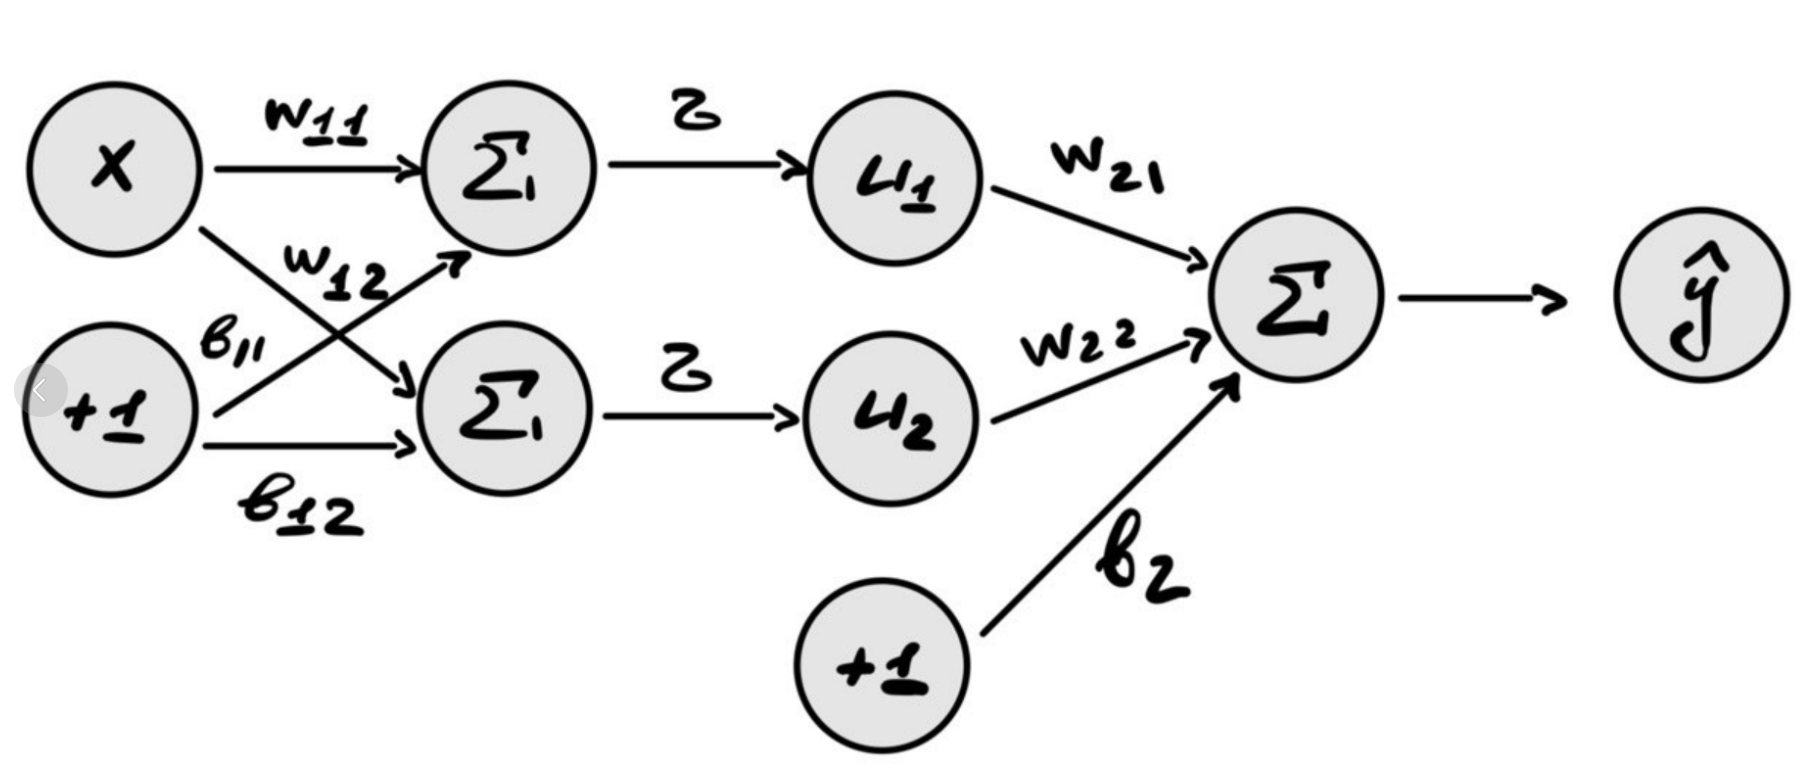

Количесвто обучаемых параметров рано количеству весов, т.е. всего их 7.

**2.** Пусть нам дана обучающая выборка $(X_1, Y_1), ..., (X_n, Y_n)$, где $X_i \in \mathbb{R}$ и $Y_i \in \mathbb{R}$. Нейронная сеть обучается по этой выборке, минимизируя заданную функцию $L$ &mdash; функцию ошибки. Положим, что $L$ &mdash; это MSE:
$$\text{MSE} = L(X, Y) = \frac{1}{n}\sum_{i=1}^n \big(Y_i - \widehat{y}(X_i)\big)^2.$$

Наша задача &mdash; найти оптимальные параметры нашей модели для минимизации $L(X, Y)$ на заданном наборе данных. Мы будем решать эту задачу с помощью градиентного спуска. Для этого нам понадобится выписать производные по всем параметрам сети. Конечно, в данном случае довольно просто выписать все производные напрямую. Однако мы воспользуемся следующей хитростью: мы будем считать производные поэтапно, причем начнем с конца вычислительной цепочки и, используя формулу производной сложной функции, последовательно посчитаем все необходимые производные. Этот процесс называется методом **обратного распространения ошибки (backpropagation)**.


**2.1.** Начнем с производной MSE по выходам сети:
$$\frac{\partial\:\text{MSE}}{\partial \widehat{y}(X_i)} = \; - \frac{2}{n} \sum_{i = 1}^n (Y_i - \hat{y}(X_i))$$

**2.2** Возьмем производные выходов сети по параметрам последнего слоя

$$\frac{\partial \widehat{y}(X_i)}{\partial w_{2h}} = \; u_h(X_i)$$

$$\frac{\partial \widehat{y}(X_i)}{\partial b_2} = \; 1$$

Также выпишем производные выходов сети по входам последнего слоя:

$$\frac{\partial \widehat{y}(X_i)}{\partial u_h(X_i)} = \; w_{2h}$$

Теперь выпишем производные MSE по параметрам и входам последнего слоя. Для этого вспомните правило производной сложной функции из математического анализа. Обратите внимание на то, что нам не нужно прописывать все производные до конца, достаточно заполнить пропуски в записи ниже:

$$\frac{\partial\:\text{MSE}}{\partial w_{2h}} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \hat{y}(X_i)} \frac{\partial \hat{y}(X_i)}{\partial w_{2h}}$$

$$\frac{\partial\:\text{MSE}}{\partial b_2} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \hat{y}(X_i)} \frac{\partial \hat{y}(X_i)}{\partial b_2}$$

$$\frac{\partial\:\text{MSE}}{\partial u_h} = \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial \hat{y}(X_i)} \frac{\partial \hat{y}(X_i)}{\partial u_h}$$

**2.3.** Теперь будем разбираться с производными по параметрам первого слоя.

Для начала нам пригодится производная функции активации, запишите ее так, чтобы ответе осталась функция от $\sigma(x)$:

$$\frac{\partial\:\sigma(x)}{\partial x} = \; \sigma(x)(1 - \sigma(x))$$

Теперь возьмем производные выходов первого слоя по его параметрам:

$$\frac{\partial u_h(X_i)}{\partial w_{1h}} = \; x$$

$$\frac{\partial u_h(X_i)}{\partial b_{1h}} = \; 1$$

Наконец, выпишем производные MSE по параметрам первого слоя. Так же как и раньше достаточно заполнить пропуски в записи ниже:

$$\frac{\partial\:\text{MSE}}{\partial w_{1h}} = \; \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial u_h(X_i)} \frac{\partial u_h(X_i)}{\partial w_{1h}}$$

$$\frac{\partial\:\text{MSE}}{\partial b_{1h}} = \; \sum_{i=1}^n \frac{\partial\:\text{MSE}}{\partial u_h(X_i)} \frac{\partial u_h(X_i)}{\partial b_{1h}}$$

**3.** Пусть обучающая выборка очень большая. Что нужно делать в таком случае? Запишите, как нужно поменять правило обновления параметров.

Когда обучающая выборка очень большая, эффективным подходом является использование SGD по батчам. Вместо использования всех данных на каждом шаге, выбирается случайный небольшой батч, и градиент рассчитывается и обновляются параметры на основе этого батча. Это позволяет более эффективно использовать большие наборы данных и ускоряет процесс обучения.

Тогда правило обновления параметров будет иметь вид:

$\theta_{t+1} = \theta_t - \alpha \nabla L(\theta_t, X_i, Y_i)$

где:
- $\theta_t$ - параметры на шаге t,
- $\alpha$ - скорость обучения
- $\nabla L(\theta_t, X_i, Y_i)$ - градиент функции потерь по параметрам, вычисленный на основе случайного батча $(X_i, Y_i)$.

**Вывод:**

Мы исследовали структуру и процесс обучения двуслойной нейронной сети, проанализировав количество обучаемых параметров и выведя производные для использования в градиентном спуске. В контексте больших данных было предложено использовать SGD по батчам для эффективного и быстрого обучения.

